#### *Problem Statement*

**An airline retail site wants to optimize booking journey in real time for customers based on their travel intent. They offer hotel, cabs and experiences (ancillary) cross sell during flight sales and want to increase this cross sell conversion. If they have user propensities to ancillary purchase, they can optimize the flight summary page or even the confirmation page to include relevant offers around cross sell.**

#### *Tool Stack*

**Airline has clickstream tracking via Adobe Analytics and content management via Adobe Target. There is s CRM CDP but is not connected to online tracking via unified ID. This limits our visibility to historical customer booking behaviour.  
There is a robust data layer which captures all values ultimately passed into Adobe Analytics.**

#### *Solution Approach*

**We will try to solve this problem in 4 steps**  
1. We will build a classification model on the booking detials of all customers. We get booking details form Adobe Analytics dat a warehouse.
2. Ideally this model output should be directly actionable but since that's not possible here (lack of cetralized customer data warehouse), we will instead analyze feature importance from the model above using SHAP values.
3. We will next build a cluster model (unspuervised learning) from the SHAP values to determine feature values critical in purchase propensity.
4. These values can then be utilized directly in Adobe Target to build customized experinces for the cohort with higher propensity. 
  
  
This solution is relevant to any e-commerce use case where there is online data collection (form, widgets etc.) leading onto customer trasanction.



### Import essential libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Evaluation Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score, make_scorer, ConfusionMatrixDisplay, classification_report

# Split data
from sklearn.model_selection import train_test_split

# preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

# CV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

#XGBoost
import xgboost
from xgboost import XGBClassifier

#shap
import shap

#kmeans
from sklearn.cluster import KMeans


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Load the dataset

I have created a dummy dataset of 10k observations. Because of the artificial origin of the dataset, its highly unlikely that it will reflect any trend in classification. Actual scenarios with larget datasets will usually perform much better than baseline scores in classification modelling.

In [2]:
# data set is already preprocessed in a separate workflow
raw_data = pd.read_csv('data_s.csv')
df = raw_data.copy()
df.head()

,cabin,passenger_adults,passenger_children,passenger_infant,passenger_youngsters,time_to_flight,connections_flag,travel_duration,destination_cont,a_purchase
0,Economy,1,0,0,0,16,0,6,EU,0
1,Economy,1,0,0,0,8,0,2,EU,0
2,Economy,1,0,0,0,78,0,8,USA,0
3,Economy,1,0,0,0,26,0,133,EU,0
4,Economy,1,0,0,0,71,0,3,EU,0


The dataset has 9 predictor features and 1 Target (a_purchase). Here is what they mean - 

![Column Definitions](columns.jpg)

### Examining the dataset

In [3]:
# how many bookings and features
df.shape

(10000, 10)

In [4]:
# feature datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cabin                 10000 non-null  object
 1   passenger_adults      10000 non-null  int64 
 2   passenger_children    10000 non-null  int64 
 3   passenger_infant      10000 non-null  int64 
 4   passenger_youngsters  10000 non-null  int64 
 5   time_to_flight        10000 non-null  int64 
 6   connections_flag      10000 non-null  int64 
 7   travel_duration       10000 non-null  int64 
 8   destination_cont      10000 non-null  object
 9   a_purchase            10000 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 781.4+ KB


##### <span style="color:blue">We have two categorical features and rest eight are numeric.</span>

In [5]:
# split of target variable 'a_purchase'
df['a_purchase'].value_counts(normalize = True)

0    0.8775
1    0.1225
Name: a_purchase, dtype: float64

##### <span style="color:blue">The split is almost 9:1 meaning 90% of bookings are flight only and rest 10% are flight and hotels.</span>

### Calculating baseline evaluation metric

Given the dataset is imbalanced, we need to fixate on a proper evaluation metric even before we train the model. Focussing on confusion matrix, accuracy wont be a right metric given the large TNs. F Score can be an option.
We are planning to apply treatment on the model's prediction and the treatment is assumed to be inexpensive to act (a/b test, mass email). 
We want to capture largest possible fraction of the condition postive samples even if FPs will be large as a result. Hence we can use recall or f_beta with beta > 1 (1.5 or 2)
##### <span style="color:blue">We will go with F_2 Score in this case</span>

In [6]:
# The most accurate predictions you can make if you only use the target variable (no features, no ML model) 
# is to predict that all points belong to the most populous class. However, for f_beta score, we will have to assume that 
# all predictions equal to 1 or else Precision will be undefined.

y_true = np.array(df['a_purchase']) # the true classification labels of the dataset
y_pred = np.ones(len(y_true),dtype=int)

print(y_true)
print(y_pred) # the predicted classification labels
print(confusion_matrix(y_true,y_pred))
print('accuracy',accuracy_score(y_true,y_pred))
print('recall',recall_score(y_true,y_pred))
print('precision',precision_score(y_true,y_pred))
print('f_2',fbeta_score(y_true,y_pred,beta = 2))

[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[[   0 8775]
 [   0 1225]]
accuracy 0.1225
recall 1.0
precision 0.1225
f_2 0.41107382550335575


##### <span style="color:blue"> Hence we get a baseline F_2 Score of 0.41 that we need to beat with our models</span>

### Split data

In [7]:
# separate the feature matrix X, and target variable y
y = df['a_purchase'] # remember, we want to predict who bought hotels with flights vs only flights
X = df.loc[:, df.columns != 'a_purchase'] # all other columns are features
print(y)
print(X.head())

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: a_purchase, Length: 10000, dtype: int64
     cabin  passenger_adults  passenger_children  passenger_infant  \
0  Economy                 1                   0                 0   
1  Economy                 1                   0                 0   
2  Economy                 1                   0                 0   
3  Economy                 1                   0                 0   
4  Economy                 1                   0                 0   

   passenger_youngsters  time_to_flight  connections_flag  travel_duration  \
0                     0              16                 0                6   
1                     0               8                 0                2   
2                     0              78                 0                8   
3                     0              26                 0              133   
4                     0          

In [8]:
# Stratified splits
random_state = 43  # hitchhiker's guide to the galaxy +1

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.8,stratify=y,random_state=random_state)
# very little variation (in the 4th decimal point only) which is important if the problem is imbalanced
print('training set:',X_train.shape, y_train.shape) # 80% of points are in train
print('test set:',X_test.shape, y_test.shape) # 20% of points are in test
print('**balance with stratification:**')
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

training set: (8000, 9) (8000,)
test set: (2000, 9) (2000,)
**balance with stratification:**
0    0.8775
1    0.1225
Name: a_purchase, dtype: float64
0    0.8775
1    0.1225
Name: a_purchase, dtype: float64


### Preprocess data


In [9]:
# collect which encoder to use on each feature
# needs to be done manually

onehot_ftrs = ['cabin','destination_cont']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs)], remainder = 'passthrough')
    
clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

preprocessor.set_output(transform = 'pandas')
X_train_prep = clf.fit_transform(X_train)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)

print(np.mean(X_train_prep,axis=0))
print(np.std(X_train_prep,axis=0))
print(np.mean(X_test_prep,axis=0))
print(np.std(X_test_prep,axis=0))

(8000, 9)
(8000, 17)
onehot__cabin_Business              0.142750
onehot__cabin_Economy               0.776625
onehot__cabin_First                 0.006375
onehot__cabin_Premium Economy       0.074250
onehot__destination_cont_AF         0.049125
onehot__destination_cont_AS         0.088750
onehot__destination_cont_EU         0.673250
onehot__destination_cont_OC         0.003750
onehot__destination_cont_SA         0.006125
onehot__destination_cont_USA        0.179000
remainder__passenger_adults         1.549125
remainder__passenger_children       0.120000
remainder__passenger_infant         0.020500
remainder__passenger_youngsters     0.040875
remainder__time_to_flight          88.060625
remainder__connections_flag         0.296750
remainder__travel_duration         15.251000
dtype: float64
onehot__cabin_Business              0.349818
onehot__cabin_Economy               0.416508
onehot__cabin_First                 0.079589
onehot__cabin_Premium Economy       0.262177
onehot__destination

In [10]:
X_train_prep.head()

,onehot__cabin_Business,onehot__cabin_Economy,onehot__cabin_First,onehot__cabin_Premium Economy,onehot__destination_cont_AF,onehot__destination_cont_AS,onehot__destination_cont_EU,onehot__destination_cont_OC,onehot__destination_cont_SA,onehot__destination_cont_USA,remainder__passenger_adults,remainder__passenger_children,remainder__passenger_infant,remainder__passenger_youngsters,remainder__time_to_flight,remainder__connections_flag,remainder__travel_duration
1283,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,22,1,7
9880,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,165,0,18
7717,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0,0,0,96,0,5
6264,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,29,0,4
4998,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0,69,0,14


### XGBoost Classifier

In [11]:
# customizing for our fbeta_score metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

param_grid = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
model = XGBClassifier()
xgb_grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring=ftwo_scorer,n_jobs=4, cv=5)
xgb_grid.fit(X_train_prep,y_train)
xgb_grid.best_params_, xgb_grid.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.34318846757451327)

In [12]:
model = XGBClassifier(max_depth = 9, min_child_weight = 1)
model.fit(X_train_prep,y_train)
target = model.predict(X_test_prep)
print(classification_report(y_test,target,target_names=['flights only','flight+hotel']))
print(accuracy_score(y_test,target)*100)
print(fbeta_score(y_test,target, beta = 2)*100)

              precision    recall  f1-score   support

flights only       0.91      0.96      0.94      1755
flight+hotel       0.56      0.35      0.43       245

    accuracy                           0.89      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.87      0.89      0.87      2000

88.64999999999999
37.91887125220458


The model yeilds f2 score of 38 whereas baseline score was 41. This means that our model is not any more effective than a simple intuition or guess. It is expected in a dummy dataset. Had it been a real dataset, then it would have implied no value in further analysis. 

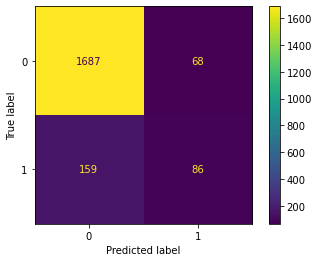

In [13]:
sns.reset_orig()
cm = confusion_matrix(y_test, target, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

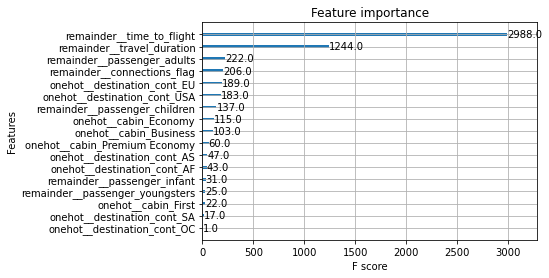

In [14]:
# Here we try out the probability based global feature importance calcuations that come with XGBoost.
xgboost.plot_importance(model)
plt.show()

### Shapley Values

SHAP feature importance is an alternative to permutation feature importance. There is a big difference between both importance measures: Permutation feature importance is based on the decrease in model performance. SHAP is based on magnitude of feature attributions.  
The Shapley value is the average contribution of a feature value to the prediction in different coalitions. Hence its best suited to determine importance of the features working togather.

In [15]:
# creating a combined train and test processed dataset
X_prep = X_train_prep.append(X_test_prep)

#### Explain predictions

In [16]:
shap.initjs() # required for visualizations later on
# create the explainer object with the model
# Here we use the Tree SHAP implementation integrated into XGBoost to explain the entire dataset (10000 samples).
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_prep,check_additivity=False)
print(np.shape(shap_values))

(10000, 17)


#### Visualize single (local) predictions

In [17]:
index = 100
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], X_prep.iloc[index,:])

-2.313921


SHAP values to explain the predicted ancillary purchase of an individual flight search. The baseline – the average predicted probability – is -2.314. This search has a lower predicted  probability of -4.06. Purchase increasing effects such as travel duration of 5 days are offset by decreasing effects such as only one adult passenger.

#### Visualize many predictions

In [18]:
# The plot consists of many force plots, each of which explains the prediction of an instance. 
# We rotate the force plots vertically and place them side by side according to their clustering similarity
# We visualize only first 1000 predictions
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_prep.iloc[:1000,:])

Stacked SHAP explanations clustered by explanation similarity. Each position on the x-axis is an instance of the data. Red SHAP values increase the prediction, blue values decrease it. One cluster stands out: On the right is a group with a high predicted propensity to purchase.

#### SHAP Feature Importance

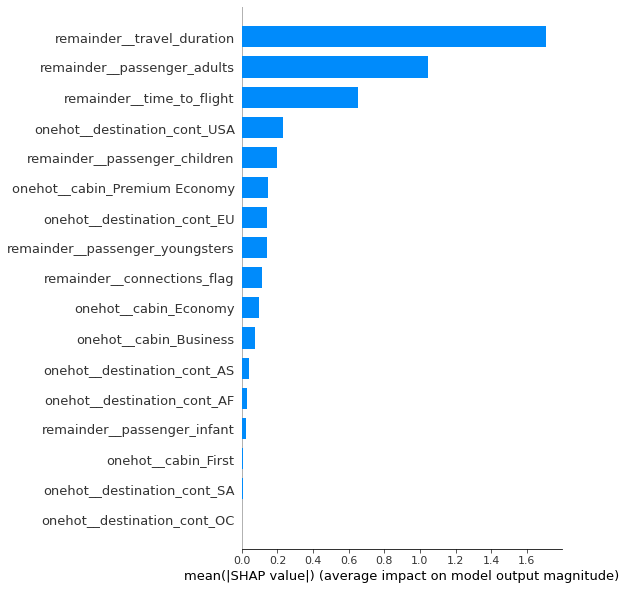

In [19]:
shap.summary_plot(shap_values, X_prep, plot_type="bar")

SHAP feature importance measured as the mean absolute Shapley values. Travel Duration was the most important feature, changing the predicted absolute purchase probability on average by 1500 percentage points (1.5 on x-axis).

#### SHAP Summary Plot

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high.

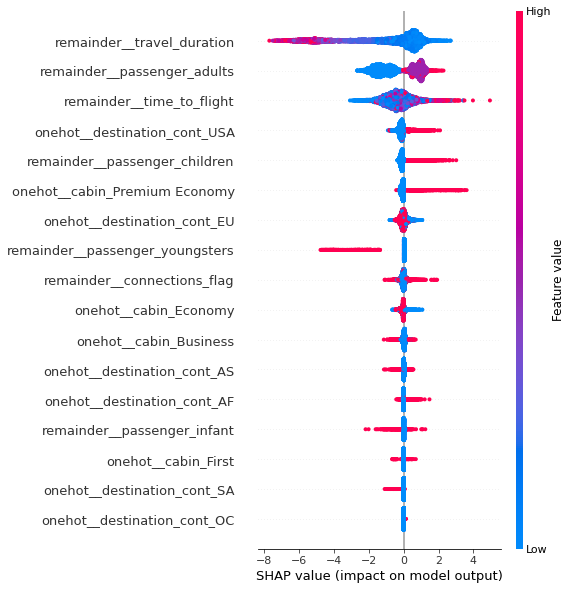

In [20]:
shap.summary_plot(shap_values, X_prep)

SHAP summary plot. Low number of days for travel duration increases the predicted propensity to purchase, a large number of days decreases the propensity. Your regular reminder: All effects describe the behavior of the model and are not necessarily causal in the real world.  
 It is interesting to note that the travel duration feature has more total model impact than the time_to_flight feature, but for those samples where time_to_flight matters it has more impact than adult_passengers. In other words, time_to_travel effects a few predictions by a large amount, while adult_passengers effects all predictions by a smaller amount.

#### SHAP Dependence Plot

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

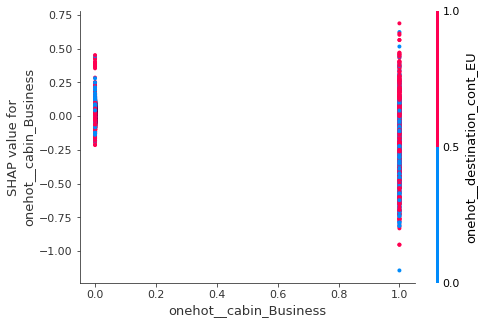

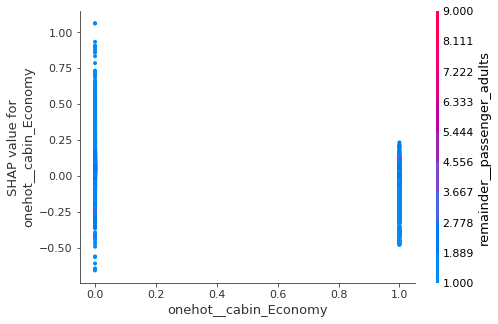

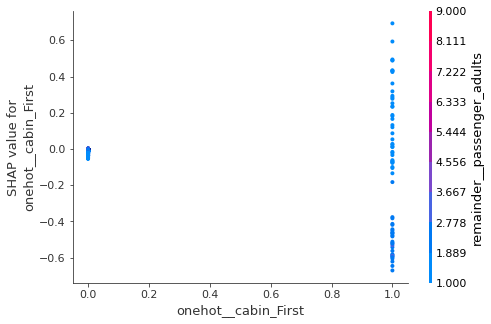

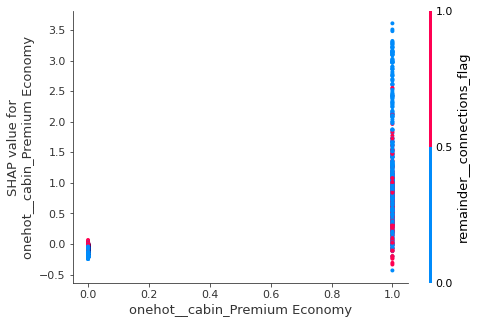

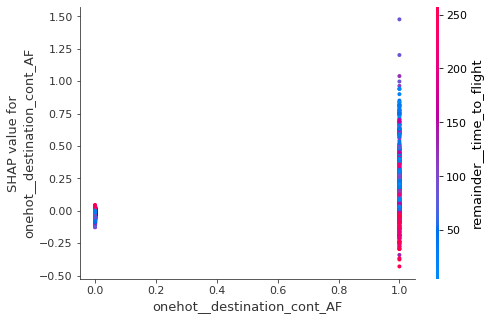

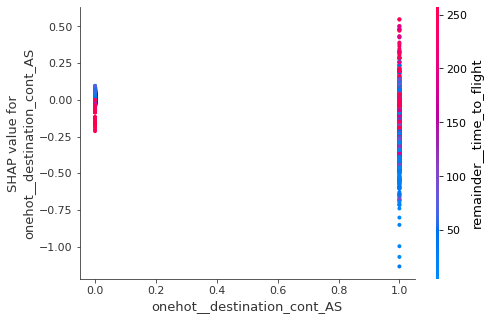

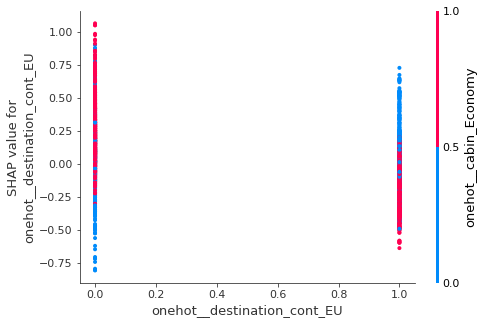

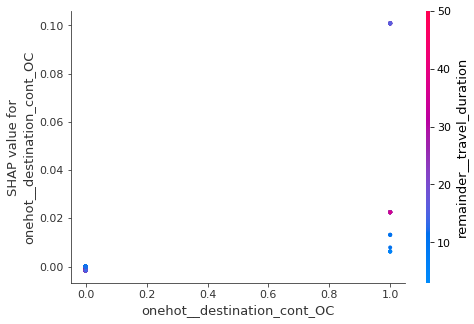

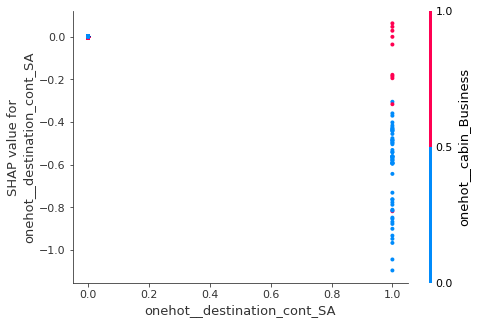

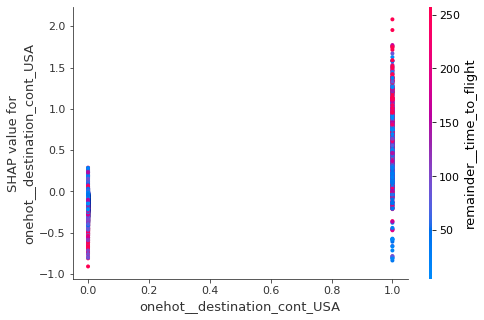

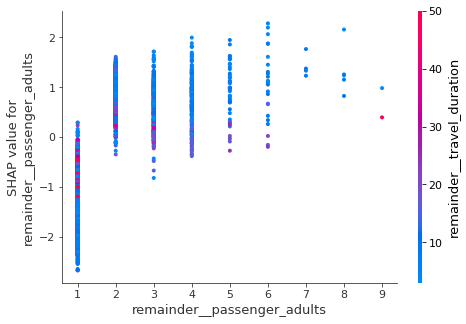

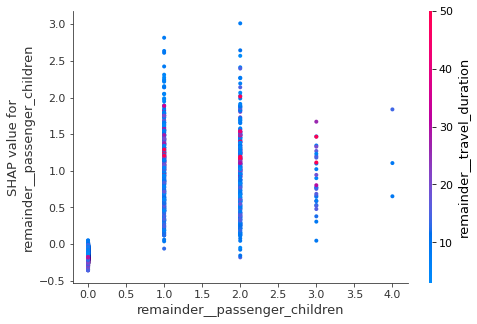

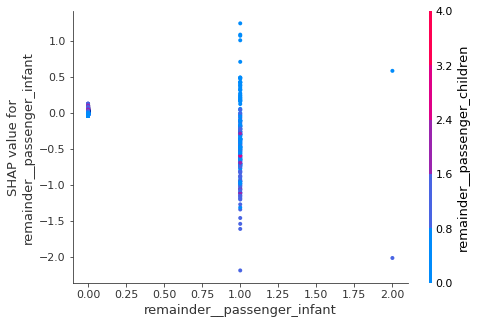

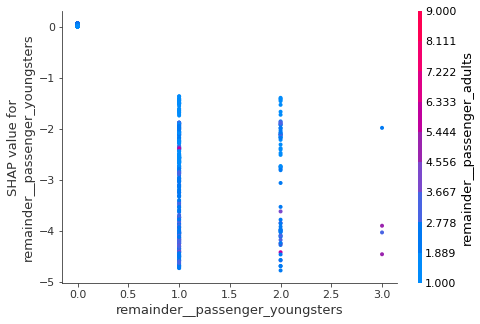

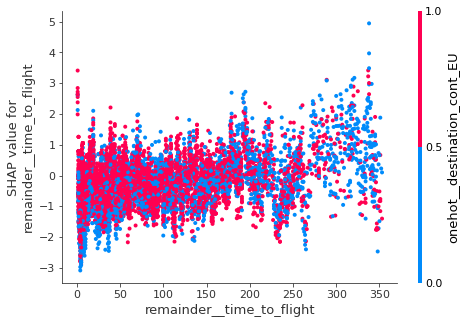

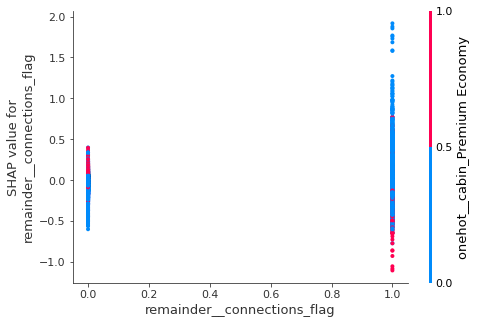

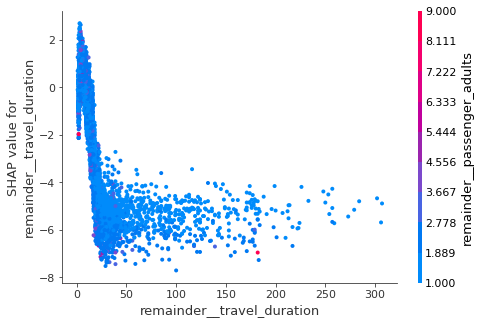

In [21]:
for name in X_prep.columns:
    shap.dependence_plot(name, shap_values, X_prep, display_features=X_prep)

SHAP feature dependence plot with interaction visualization. Adult_passengers interacts with travel duration. For more adults travelling, longer travel duration reduces the predicted propensity. Again, this is not a causal model.

### SHAP Values Clustering (Unsupervised Learning)

Clustering bookings by their SHAP values leads to isolate groups with high propensity to purchase and we can observe the values of respective features for those groups.

In [22]:
# standardizing the shap values array
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(shap_values)

In [23]:
# determining optimal number of clsuters using elbow method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i,n_init = 'auto', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

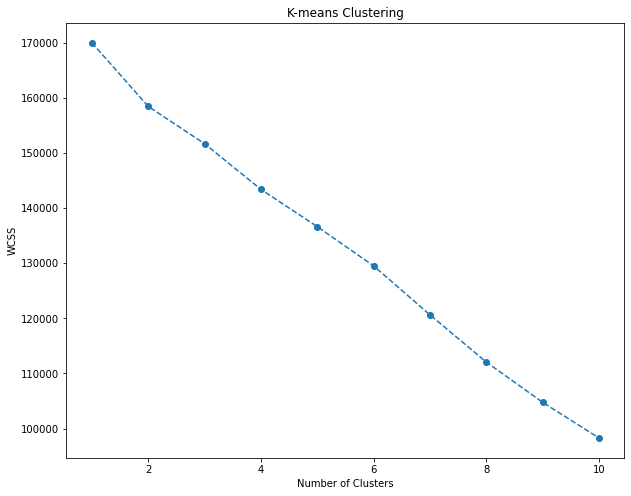

In [24]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [25]:
# optimal number of clusters are a hit and try, we went for 4 after trying out 3,4 and 5
kmeans = KMeans(n_clusters = 4, n_init = 'auto', random_state = 42)

In [26]:
kmeans.fit(segmentation_std)

KMeans(n_clusters=4, n_init='auto', random_state=42)

In [27]:
# adding it to the dataset
y_prep = y_train.append(y_test)
df_segm_kmeans = X_prep.copy()
df_segm_kmeans['a_purchase'] = y_prep
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [28]:
# analyzing the mean values of the features
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,onehot__cabin_Business,onehot__cabin_Economy,onehot__cabin_First,onehot__cabin_Premium Economy,onehot__destination_cont_AF,onehot__destination_cont_AS,onehot__destination_cont_EU,onehot__destination_cont_OC,onehot__destination_cont_SA,onehot__destination_cont_USA,remainder__passenger_adults,remainder__passenger_children,remainder__passenger_infant,remainder__passenger_youngsters,remainder__time_to_flight,remainder__connections_flag,remainder__travel_duration,a_purchase
Segment K-means,,,,,,,,,,,,,,,,,,
0,0.995946,0.001351,0.000000,0.002703,0.060811,0.144595,0.627027,0.010811,0.004054,0.152703,1.577027,0.087838,0.017568,0.022973,92.563514,0.254054,13.372973,0.050000
1,0.089574,0.823301,0.005101,0.082024,0.051010,0.105285,0.716792,0.006325,0.010610,0.109978,1.851663,0.160375,0.029994,0.072434,100.505611,0.369925,22.059988,0.112834
2,0.038173,0.929527,0.006199,0.026101,0.027080,0.048940,0.842414,0.000979,0.001631,0.078956,1.009135,0.029364,0.004894,0.006852,53.744861,0.206852,8.074062,0.016313
3,0.090417,0.691654,0.017002,0.200927,0.091963,0.078825,0.125966,0.001546,0.003091,0.698609,1.710974,0.204019,0.016229,0.027048,122.149923,0.258114,9.267388,0.452087


In [29]:
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','remainder__travel_duration']].groupby(['Segment K-means']).count()

In [30]:
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [31]:
df_segm_analysis

,onehot__cabin_Business,onehot__cabin_Economy,onehot__cabin_First,onehot__cabin_Premium Economy,onehot__destination_cont_AF,onehot__destination_cont_AS,onehot__destination_cont_EU,onehot__destination_cont_OC,onehot__destination_cont_SA,onehot__destination_cont_USA,remainder__passenger_adults,remainder__passenger_children,remainder__passenger_infant,remainder__passenger_youngsters,remainder__time_to_flight,remainder__connections_flag,remainder__travel_duration,a_purchase,N Obs,Prop Obs
Segment K-means,,,,,,,,,,,,,,,,,,,,
0,0.995946,0.001351,0.000000,0.002703,0.060811,0.144595,0.627027,0.010811,0.004054,0.152703,1.577027,0.087838,0.017568,0.022973,92.563514,0.254054,13.372973,0.050000,740,0.0740
1,0.089574,0.823301,0.005101,0.082024,0.051010,0.105285,0.716792,0.006325,0.010610,0.109978,1.851663,0.160375,0.029994,0.072434,100.505611,0.369925,22.059988,0.112834,4901,0.4901
2,0.038173,0.929527,0.006199,0.026101,0.027080,0.048940,0.842414,0.000979,0.001631,0.078956,1.009135,0.029364,0.004894,0.006852,53.744861,0.206852,8.074062,0.016313,3065,0.3065
3,0.090417,0.691654,0.017002,0.200927,0.091963,0.078825,0.125966,0.001546,0.003091,0.698609,1.710974,0.204019,0.016229,0.027048,122.149923,0.258114,9.267388,0.452087,1294,0.1294


We observe from here that segment 3 has most propensity to ancillary purchase (a_purchase mean = 0.45). Top 3 important features has following mean values - 
1. Travel duration (9.26) ~ 9 days
2. Adult passengers (1.71) ~ 2 adults
3. Time to travel (122.14) ~ 122 days

We can also use quantile theresholds to understand the range of values in the segments and based on that recommend rules for Adobe Target activation.

In [32]:
df_segm_analysis_q = df_segm_kmeans.groupby(['Segment K-means']).quantile([0.25,0.75])
df_segm_analysis_q

onehot__cabin_Business  onehot__cabin_Economy  \
Segment K-means                                                       
0               0.25                     1.0                    0.0   
                0.75                     1.0                    0.0   
1               0.25                     0.0                    1.0   
                0.75                     0.0                    1.0   
2               0.25                     0.0                    1.0   
                0.75                     0.0                    1.0   
3               0.25                     0.0                    0.0   
                0.75                     0.0                    1.0   

                      onehot__cabin_First  onehot__cabin_Premium Economy  \
Segment K-means                                                            
0               0.25                  0.0                            0.0   
                0.75                  0.0                            0.0   
1               0.25                  0.0                            0.0   
                0.75                  0.0                            0.0   
2               0.25                  0.0                            0.0   
                0.75                  0.0                            0.0   
3               0.25                  0.0                            0.0   
                0.75                  0.0                            0.0   

                      onehot__destination_cont_AF  \
Segment K-means                                     
0               0.25                          0.0   
                0.75                          0.0   
1               0.25                          0.0   
                0.75                          0.0   
2               0.25                          0.0   
                0.75                          0.0   
3               0.25                          0.0   
                0.75                          0.0   

                      onehot__destination_cont_AS  \
Segment K-means                                     
0               0.25                          0.0   
                0.75                          0.0   
1               0.25                          0.0   
                0.75                          0.0   
2               0.25                          0.0   
                0.75                          0.0   
3               0.25                          0.0   
                0.75                          0.0   

                      onehot__destination_cont_EU  \
Segment K-means                                     
0               0.25                          0.0   
                0.75                          1.0   
1               0.25                          0.0   
                0.75                          1.0   
2               0.25                          1.0   
                0.75                          1.0   
3               0.25                          0.0   
                0.75                          0.0   

                      onehot__destination_cont_OC  \
Segment K-means                                     
0               0.25                          0.0   
                0.75                          0.0   
1               0.25                          0.0   
                0.75                          0.0   
2               0.25                          0.0   
                0.75                          0.0   
3               0.25                          0.0   
                0.75                          0.0   

                      onehot__destination_cont_SA  \
Segment K-means                                     
0               0.25                          0.0   
                0.75                          0.0   
1               0.25                          0.0   
                0.75                          0.0   
2               0.25                          0.0   
                0.75                          0.0   
3 

Observing both quantiles and mean, we can recommend following theresholds for Adobe Target experirence activation (remember this is dummy data so values are not expected to make sense) - 
1. Bookings/Searches with travel duration less than 10 days
2. Number of adult passengers more than 2
3. time to travel more than 30 days
  
This is a very good set of criteria which isolates an audience/ cohort with best possible chances to purchase ancillary products. Adobe Target can create custom experience for these audiences while keeping general experience for rest of the visits. For example, an extra page highlighting ancillary products or destination themed content can be tested for this cohort in flight selling flow without risking usual experience for general users. Based on observation, experiences can be scaled to wider audience.